In [1]:
!pip -q install networkx==3.2.1 scikit-learn==1.4.2 torch torch-geometric==2.5.3 --extra-index-url https://data.pyg.org/whl/torch-2.2.0+cpu.html

import pandas as pd, numpy as np, networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import kneighbors_graph

# Targets you care about (will match common variants)
TARGET_ALIASES = {
    "FamilyMedianIncome": ["FamilyMedianIncome","family_median_income","FamilyIncome","family_income"],
    "MedianGrossRent": ["MedianGrossRent","MedianRent","median_gross_rent","median_rent"],
    "PerCapitaIncome": ["PerCapitaIncome","per_capita_income","PerCapitaInc"],
    "PovertyPercent": ["PovertyPercent","poverty_percent","PovertyRate","poverty_rate","Poverty"]
}
ID_CANDIDATES = ["GEOID","geoid","GEOID10","FIPS","fips","TRACT","tract","ZCTA","zcta","ZIP","zip","BlockGroup","block_group"]

def find_col(df, names):
    for n in names:
        if n in df.columns: return n
    return None

def map_targets(df):
    out = {}
    for k, vs in TARGET_ALIASES.items():
        c = find_col(df, vs)
        if c: out[k] = c
    return out

def cluster_r2(y, labels):
    y = np.asarray(y).reshape(-1)
    mu = y.mean()
    sst = ((y - mu)**2).sum() + 1e-12
    sse = 0.0
    for cl in np.unique(labels):
        idx = (labels == cl)
        m = y[idx].mean()
        sse += ((y[idx] - m)**2).sum()
    return 1 - sse/sst

# Load your CSV
df = pd.read_csv("/content/final.csv")
id_col = find_col(df, ID_CANDIDATES) or "_row_id"
if id_col not in df.columns:
    df[id_col] = np.arange(len(df))

targets = map_targets(df)
num_cols = [c for c in df.columns if c not in list(targets.values())+[id_col] and pd.api.types.is_numeric_dtype(df[c])]
df = df[[id_col] + num_cols + list(targets.values())].dropna(subset=num_cols).reset_index(drop=True)

# استانداردسازی
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols].values)

# df = df.sample(5000, random_state=0).reset_index(drop=True); X = X[df.index]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


**1) Stage 1 – Classical KMeans (X)**

In [2]:
K_CANDS = [10, 20, 30]
best = {"K": None, "sil": -1, "labels": None}
sil_idx = np.random.default_rng(0).choice(len(X), size=min(2000, len(X)), replace=False)

for K in K_CANDS:
    km = KMeans(n_clusters=K, n_init=10, random_state=0)
    lab = km.fit_predict(X)
    sil = silhouette_score(X[sil_idx], lab[sil_idx])
    if sil > best["sil"]:
        best = {"K": K, "sil": sil, "labels": lab}

labels_X = best["labels"]
sil_X = best["sil"]
K_X = best["K"]

# Cluster-R² برای هر تارگت
stage1_rows = []
for name, col in targets.items():
    r2 = cluster_r2(df[col].values, labels_X)
    stage1_rows.append([name, K_X, sil_X, r2])
pd.DataFrame(stage1_rows, columns=["Target","K","Silhouette(X)","Cluster-R² (KMeans-X)"])


,Target,K,Silhouette(X),Cluster-R² (KMeans-X)
0,FamilyMedianIncome,10,0.152276,0.389744
1,MedianGrossRent,10,0.152276,0.493724
2,PerCapitaIncome,10,0.152276,0.323351
3,PovertyPercent,10,0.152276,0.108091


**2) Stage 2 – Graph-based (KNN graph) + Spectral + LPA**

In [3]:
from sklearn.manifold import SpectralEmbedding

# 2a) KNN graph
k_neighbors = 10
A = kneighbors_graph(X, n_neighbors=k_neighbors, mode='connectivity', include_self=True)
G = nx.from_scipy_sparse_array(A, create_using=nx.Graph)

# 2b) Spectral embedding → KMeans
embed = SpectralEmbedding(n_components=64, affinity='nearest_neighbors', n_neighbors=k_neighbors, random_state=0)
Z = embed.fit_transform(X)

bestZ = {"K": None, "sil": -1, "labels": None}
for K in K_CANDS:
    km = KMeans(n_clusters=K, n_init=10, random_state=0)
    lab = km.fit_predict(Z)
    sil = silhouette_score(Z[sil_idx], lab[sil_idx])
    if sil > bestZ["sil"]:
        bestZ = {"K": K, "sil": sil, "labels": lab}

labels_Z = bestZ["labels"]; sil_Z = bestZ["sil"]; K_Z = bestZ["K"]

# 2c) Label Propagation
lpa_comms = list(nx.algorithms.community.asyn_lpa_communities(G, seed=0))
node2c = {}
for cid, comm in enumerate(lpa_comms):
    for u in comm: node2c[u] = cid
labels_LPA = np.array([node2c[i] for i in range(len(df))])

# Modularity
try:
    modularity = nx.algorithms.community.modularity(G, lpa_comms)
except Exception:
    modularity = np.nan

# ارزیابی‌ها
rows = []
for name, col in targets.items():
    y = df[col].values
    rows.append([
        name,
        K_X, round(sil_X,4), round(cluster_r2(y, labels_X),3),
        K_Z, round(sil_Z,4), round(cluster_r2(y, labels_Z),3),
        len(lpa_comms), round(cluster_r2(y, labels_LPA),3),
        modularity if isinstance(modularity, float) else np.nan
    ])

unsup_summary = pd.DataFrame(rows, columns=[
    "Target",
    "K_X","Silhouette(X)","Cluster-R² (KMeans-X)",
    "K_Z","Silhouette(Z)","Cluster-R² (Spectral+KMeans)",
    "LPA #comms","Cluster-R² (LPA)","LPA Modularity"
])
unsup_summary


,Target,K_X,Silhouette(X),Cluster-R² (KMeans-X),K_Z,Silhouette(Z),Cluster-R² (Spectral+KMeans),LPA #comms,Cluster-R² (LPA),LPA Modularity
0,FamilyMedianIncome,10,0.1523,0.390,30,0.0855,0.357,32698,1.0,0.136151
1,MedianGrossRent,10,0.1523,0.494,30,0.0855,0.458,32698,1.0,0.136151
2,PerCapitaIncome,10,0.1523,0.323,30,0.0855,0.332,32698,1.0,0.136151
3,PovertyPercent,10,0.1523,0.108,30,0.0855,0.102,32698,1.0,0.136151


**3) Stage 3 – Unsupervised GNN Embeddings**

**A. GCN-based Graph Autoencoder (GAE)**

In [4]:
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv

# ساخت دادهٔ PyG از ماتریس A
edge_index, _ = from_scipy_sparse_matrix(A)
x = torch.tensor(X, dtype=torch.float32)
data = Data(x=x, edge_index=edge_index)

# Encoder: GCN → embedding d=64
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid=64, out=64):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid)
        self.conv2 = GCNConv(hid, out)
        self.act = nn.ReLU()
    def forward(self, x, edge_index):
        h = self.act(self.conv1(x, edge_index))
        z = self.conv2(h, edge_index)
        return z

enc = GCNEncoder(x.size(1), hid=128, out=64)
dec = lambda z, ei: (z[ei[0]] * z[ei[1]]).sum(dim=1)  # inner-product decoder

opt = torch.optim.Adam(enc.parameters(), lr=1e-3, weight_decay=1e-4)
edge_label_index = edge_index  # positive edges
# برای نگاتیوها:
from torch_geometric.utils import negative_sampling
for epoch in range(200):
    enc.train(); opt.zero_grad()
    z = enc(data.x, data.edge_index)
    pos_out = dec(z, edge_label_index)
    neg_ei = negative_sampling(edge_index, num_nodes=z.size(0), num_neg_samples=pos_out.numel())
    neg_out = dec(z, neg_ei)
    # باینری کراس‌انتروپی روی logits
    loss = nn.functional.binary_cross_entropy_with_logits(
        torch.cat([pos_out, neg_out]),
        torch.cat([torch.ones_like(pos_out), torch.zeros_like(neg_out)])
    )
    loss.backward(); opt.step()

enc.eval()
with torch.no_grad():
    Z_gae = enc(data.x, data.edge_index).cpu().numpy()

# کلاستر روی Z_gae
km = KMeans(n_clusters=K_Z or 20, n_init=10, random_state=0)
lab_gae = km.fit_predict(Z_gae)

# ارزیابی
rows_gae = []
for name, col in targets.items():
    y = df[col].values
    rows_gae.append([name, round(cluster_r2(y, lab_gae),3)])
pd.DataFrame(rows_gae, columns=["Target","Cluster-R² (GAE+KMeans)"])


,Target,Cluster-R² (GAE+KMeans)
0,FamilyMedianIncome,0.414
1,MedianGrossRent,0.470
2,PerCapitaIncome,0.365
3,PovertyPercent,0.173


**b) GraphSAGE (unsupervised) with sampling و contrastive loss**

In [6]:
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader

class SAGEEncoder(nn.Module):
    def __init__(self, in_dim, hid=128, out=64):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid)
        self.conv2 = SAGEConv(hid, out)
        self.act = nn.ReLU()
    def forward(self, x, edge_index):
        h = self.act(self.conv1(x, edge_index))
        z = self.conv2(h, edge_index)
        return z

sage = SAGEEncoder(x.size(1), hid=128, out=64)
opt = torch.optim.Adam(sage.parameters(), lr=1e-3, weight_decay=1e-4)

# ساده‌ترین loss: نزدیک‌کردن positive (همسایه‌ها) و دورکردن negative (sampling تصادفی)
def contrastive_loss(z, pos_pairs, neg_pairs, margin=0.5):
    pos = ((z[pos_pairs[:,0]] - z[pos_pairs[:,1]])**2).sum(1).sqrt()
    neg = ((z[neg_pairs[:,0]] - z[neg_pairs[:,1]])**2).sum(1).sqrt()
    return pos.mean() + torch.clamp(margin - neg, min=0).mean()

# تولید زوج‌ها
edges = edge_index.t().cpu().numpy()
pos_pairs = torch.tensor(edges, dtype=torch.long)
rng = np.random.default_rng(0)
neg_pairs = torch.tensor(
    np.column_stack([rng.integers(0, x.size(0), size=len(edges)),
                     rng.integers(0, x.size(0), size=len(edges))]),
    dtype=torch.long
)

for epoch in range(200):
    sage.train(); opt.zero_grad()
    z = sage(data.x, data.edge_index)
    loss = contrastive_loss(z, pos_pairs, neg_pairs, margin=0.5)
    loss.backward(); opt.step()

sage.eval()
with torch.no_grad():
    Z_sage = sage(data.x, data.edge_index).cpu().numpy()

lab_sage = KMeans(n_clusters=K_Z or 20, n_init=10, random_state=0).fit_predict(Z_sage)

rows_sage = []
for name, col in targets.items():
    y = df[col].values
    rows_sage.append([name, round(cluster_r2(y, lab_sage),3)])
pd.DataFrame(rows_sage, columns=["Target","Cluster-R² (GraphSAGE+KMeans)"])


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

############

In [8]:
# ====== Colab Setup (NO heavy installs needed) ======
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

# ---- Load your dataset ----
df = pd.read_csv('/content/final.csv')

TARGET_ALIASES = {
    "FamilyMedianIncome": ["FamilyMedianIncome","family_median_income","FamilyIncome","family_income"],
    "MedianGrossRent": ["MedianGrossRent","MedianRent","median_gross_rent","median_rent"],
    "PerCapitaIncome": ["PerCapitaIncome","per_capita_income","PerCapitaInc"],
    "PovertyPercent": ["PovertyPercent","poverty_percent","PovertyRate","poverty_rate","Poverty"],
}
ID_CANDS = ["GEOID","geoid","GEOID10","FIPS","fips","TRACT","tract","ZCTA","zcta","ZIP","zip","BlockGroup","block_group"]

def find_col(df, names):
    for n in names:
        if n in df.columns: return n
    return None

id_col = find_col(df, ID_CANDS) or "_row_id"
if id_col not in df.columns:
    df[id_col] = np.arange(len(df))

targets = {}
for k, vs in TARGET_ALIASES.items():
    c = find_col(df, vs)
    if c: targets[k] = c

exclude = set([id_col] + list(targets.values()))
num_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
df_use = df[[id_col] + num_cols + list(targets.values())].dropna(subset=num_cols).reset_index(drop=True)

# (اختیاری) نمونه‌گیری برای سرعت
N_MAX = 8000     # اگر Colab کند بود، بکنش 3000–5000
if len(df_use) > N_MAX:
    df_use = df_use.sample(N_MAX, random_state=0).reset_index(drop=True)

# ---- Standardize X ----
scaler = StandardScaler()
X = scaler.fit_transform(df_use[num_cols].values)

# ========= Stage 1: KMeans on X =========
K = 30  # یا یکی از {10,20,30}
kmX = KMeans(n_clusters=K, n_init=10, random_state=0).fit(X)
sil_idx = np.random.default_rng(0).choice(len(X), size=min(2000, len(X)), replace=False)
sil_X = float(silhouette_score(X[sil_idx], kmX.labels_[sil_idx]))

def cluster_r2(y, labels):
    y = np.asarray(y).reshape(-1)
    mu = y.mean()
    sst = ((y - mu)**2).sum() + 1e-12
    sse = 0.0
    for cl in np.unique(labels):
        idx = (labels == cl)
        m = y[idx].mean()
        sse += ((y[idx] - m)**2).sum()
    return 1 - sse/sst

# ========= Stage 2: Graph-aware (GCN-like smoothing) =========
# Build 10-NN graph on X (sparse)
k = 10
A = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=True)
row_sums = np.asarray(A.sum(axis=1)).reshape(-1) + 1e-12
Dinv = 1.0 / row_sums
Z1 = (A @ X) * Dinv[:, None]       # 1-hop smoothing
Z2 = (A @ Z1) * Dinv[:, None]      # 2-hop smoothing

kmZ1 = KMeans(n_clusters=K, n_init=10, random_state=0).fit(Z1)
kmZ2 = KMeans(n_clusters=K, n_init=10, random_state=0).fit(Z2)
sil_Z1 = float(silhouette_score(Z1[sil_idx], kmZ1.labels_[sil_idx]))
sil_Z2 = float(silhouette_score(Z2[sil_idx], kmZ2.labels_[sil_idx]))

# ---- Summaries ----
rows = []
for cname, col in targets.items():
    y = df_use[col].values
    rows.append([cname, K,
                 round(sil_X,4),  round(cluster_r2(y, kmX.labels_),3),
                 round(sil_Z1,4), round(cluster_r2(y, kmZ1.labels_),3),
                 round(sil_Z2,4), round(cluster_r2(y, kmZ2.labels_),3)])

summary = pd.DataFrame(rows, columns=[
    "Target","K",
    "Silhouette (X)","Cluster-R² (X)",
    "Silhouette (Z1=1-hop)","Cluster-R² (Z1)",
    "Silhouette (Z2=2-hop)","Cluster-R² (Z2)"
])
summary


,Target,K,Silhouette (X),Cluster-R² (X),Silhouette (Z1=1-hop),Cluster-R² (Z1),Silhouette (Z2=2-hop),Cluster-R² (Z2)
0,FamilyMedianIncome,30,0.1377,0.514,0.1819,0.507,0.2149,0.488
1,MedianGrossRent,30,0.1377,0.554,0.1819,0.557,0.2149,0.558
2,PerCapitaIncome,30,0.1377,0.448,0.1819,0.447,0.2149,0.413
3,PovertyPercent,30,0.1377,0.175,0.1819,0.160,0.2149,0.160


# Task
Analyze the provided dataset by applying KMeans clustering to the original features (X), 1-hop smoothed features (Z1), and 2-hop smoothed features (Z2). Evaluate and compare the resulting clusters using appropriate metrics and visualizations to understand the characteristics of the clusters and the effectiveness of the different feature representations for clustering.

## Combine results

### Subtask:
Consolidate the cluster labels from KMeans on X, 1-hop smoothed Z1, and 2-hop smoothed Z2 into a single DataFrame with the original data.


**Reasoning**:
Create a new dataframe with the cluster labels from the different KMeans models.



In [9]:
df_clustered = df_use.copy()
df_clustered['labels_X'] = kmX.labels_
df_clustered['labels_Z1'] = kmZ1.labels_
df_clustered['labels_Z2'] = kmZ2.labels_
display(df_clustered.head())

,_row_id,Unnamed: 0,Zip Code Tabulation Area,FIPS Code,Formatted FIPS,GQPercent,HouseMedianValue,AvgAnnualHouseExpenditure,VeteranPercent,MedianAge,...,NumOfHouseHolds,Population,PopulationDensity,FamilyMedianIncome,MedianGrossRent,PerCapitaIncome,PovertyPercent,labels_X,labels_Z1,labels_Z2
0,4114,4114,43724,43724,43724,25.56,97600,51600,11.81,47,...,2897,9237,59.53,57372,646,23460.0,14.74,29,16,12
1,3782,3782,77474,77474,77474,0.51,172300,63000,4.92,38,...,4548,12487,60.03,76125,933,28214.0,12.96,19,5,7
2,26765,26765,2538,2538,2538,0.44,263300,60100,8.25,40,...,1684,2692,908.02,71442,1293,31214.0,14.10,18,13,21
3,13453,13453,65732,65732,65732,0.00,144700,52700,9.39,33,...,348,1073,20.46,62768,713,19553.0,15.66,27,26,6
4,8325,8325,28091,28091,28091,0.00,79600,48400,13.38,38,...,857,1975,20.86,56411,570,21430.0,21.67,29,16,12


## Evaluate and compare clusters

### Subtask:
Calculate relevant clustering metrics (like Silhouette Score and Cluster-R²) for all successful clustering methods and potentially compare the distributions of target variables within each cluster.


**Reasoning**:
Calculate the mean of target variables within each cluster for each clustering result and store them in a DataFrame for comparison.



In [10]:
cluster_means = []
for target_name, target_col in targets.items():
    for clustering_method, labels in [('KMeans_X', df_clustered['labels_X']),
                                       ('KMeans_Z1', df_clustered['labels_Z1']),
                                       ('KMeans_Z2', df_clustered['labels_Z2'])] :
        means = df_clustered.groupby(labels)[target_col].mean().reset_index()
        means.columns = ['Cluster', 'Mean_' + target_name]
        means['Method'] = clustering_method
        means['Target'] = target_name
        cluster_means.append(means)

cluster_means_df = pd.concat(cluster_means)
display(cluster_means_df)

,Cluster,Mean_FamilyMedianIncome,Method,Target,Mean_MedianGrossRent,Mean_PerCapitaIncome,Mean_PovertyPercent
0,0,60153.978448,KMeans_X,FamilyMedianIncome,NaN,NaN,NaN
1,1,69784.260062,KMeans_X,FamilyMedianIncome,NaN,NaN,NaN
2,2,143419.800000,KMeans_X,FamilyMedianIncome,NaN,NaN,NaN
3,3,74810.278736,KMeans_X,FamilyMedianIncome,NaN,NaN,NaN
4,4,87370.533333,KMeans_X,FamilyMedianIncome,NaN,NaN,NaN
...,...,...,...,...,...,...,...
25,25,NaN,KMeans_Z2,PovertyPercent,NaN,NaN,19.656404
26,26,NaN,KMeans_Z2,PovertyPercent,NaN,NaN,23.623213
27,27,NaN,KMeans_Z2,PovertyPercent,NaN,NaN,9.837662
28,28,NaN,KMeans_Z2,PovertyPercent,NaN,NaN,11.764825


## Visualize clusters

### Subtask:
Create visualizations to explore the characteristics of the clusters and how they relate to the target variables.


**Reasoning**:
Create box plots for each target variable and clustering method using the cluster means to visualize the distribution of target variables within each cluster.



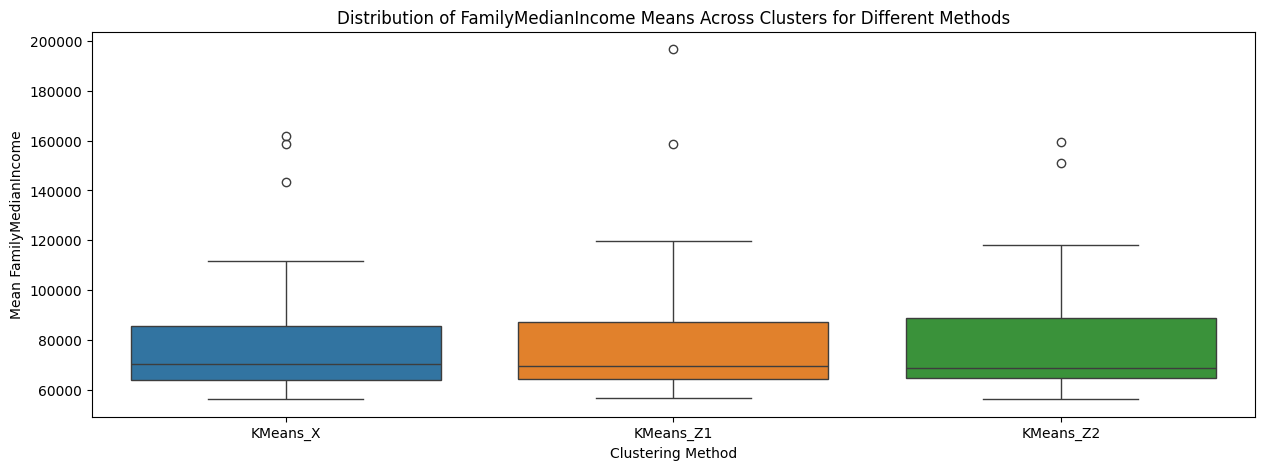

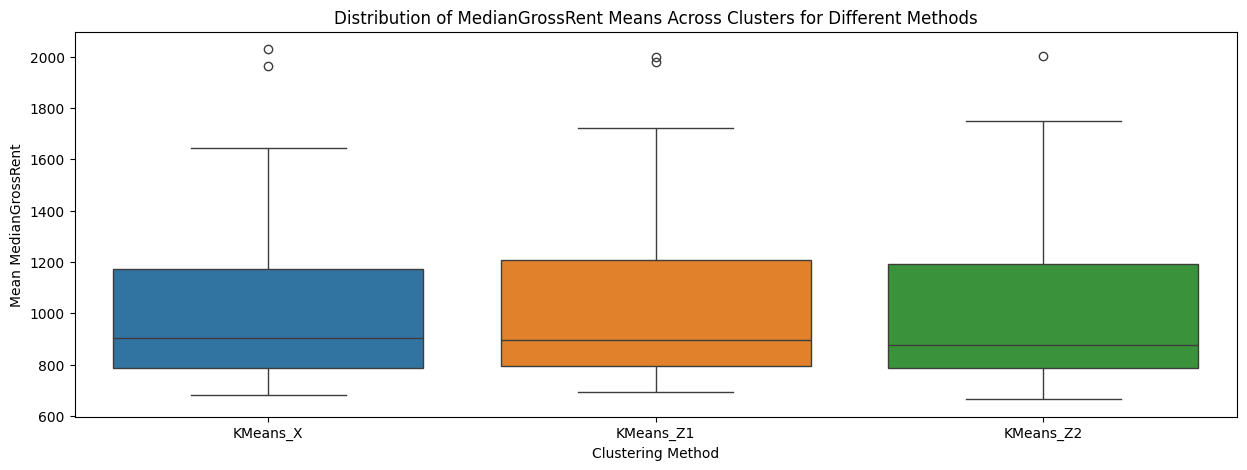

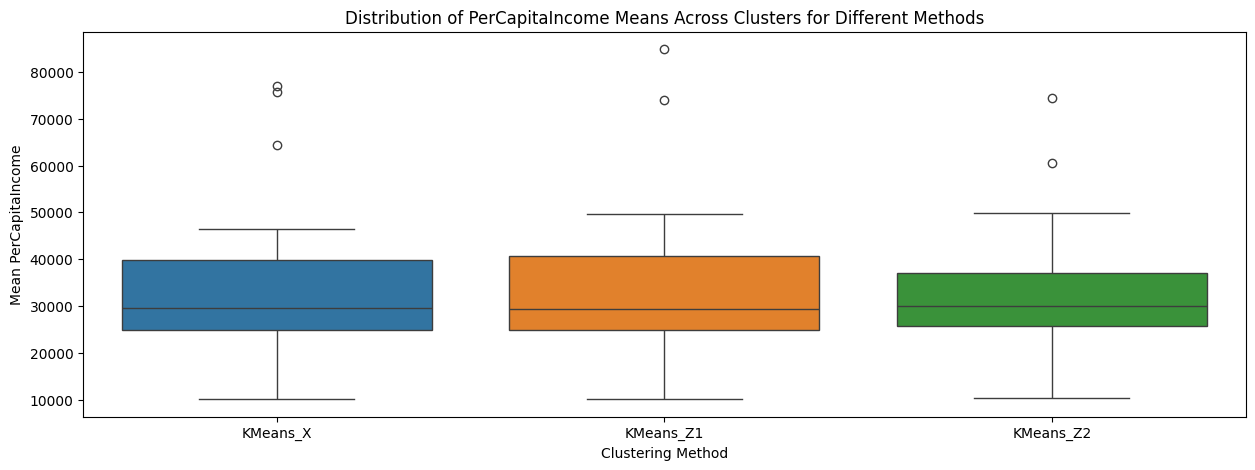

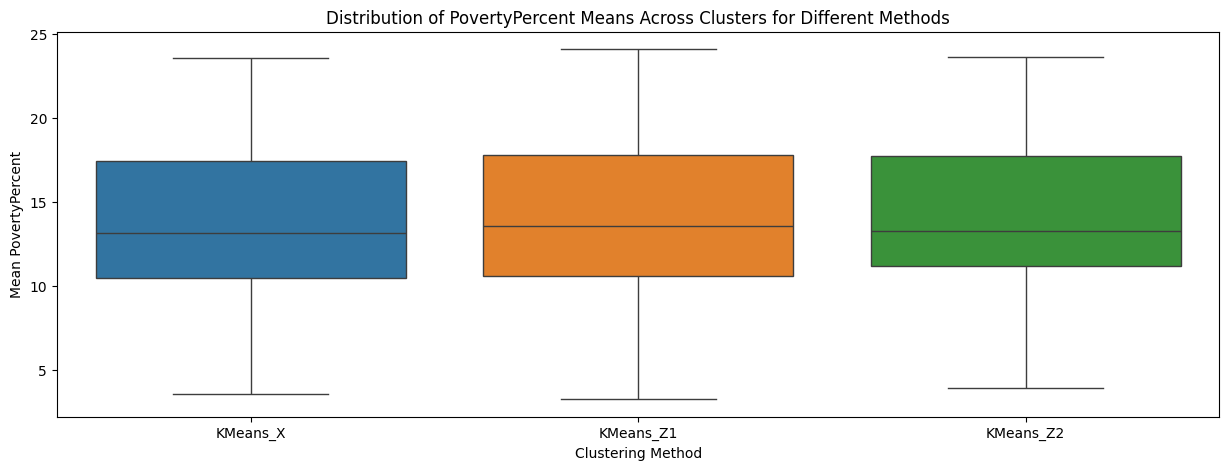

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the cluster_means_df for easier plotting with seaborn
cluster_means_melted = cluster_means_df.melt(
    id_vars=['Cluster', 'Method', 'Target'],
    var_name='Mean_Target',
    value_name='Mean_Value'
).dropna()

# Create box plots for each target and method
for target in targets.keys():
    plt.figure(figsize=(15, 5))
    subset = cluster_means_melted[cluster_means_melted['Target'] == target]
    sns.boxplot(data=subset, x='Method', y='Mean_Value', hue='Method')
    plt.title(f'Distribution of {target} Means Across Clusters for Different Methods')
    plt.ylabel(f'Mean {target}')
    plt.xlabel('Clustering Method')
    plt.show()

**Reasoning**:
Perform dimensionality reduction on the original data X using t-SNE and create scatter plots of the results colored by cluster labels from each method.



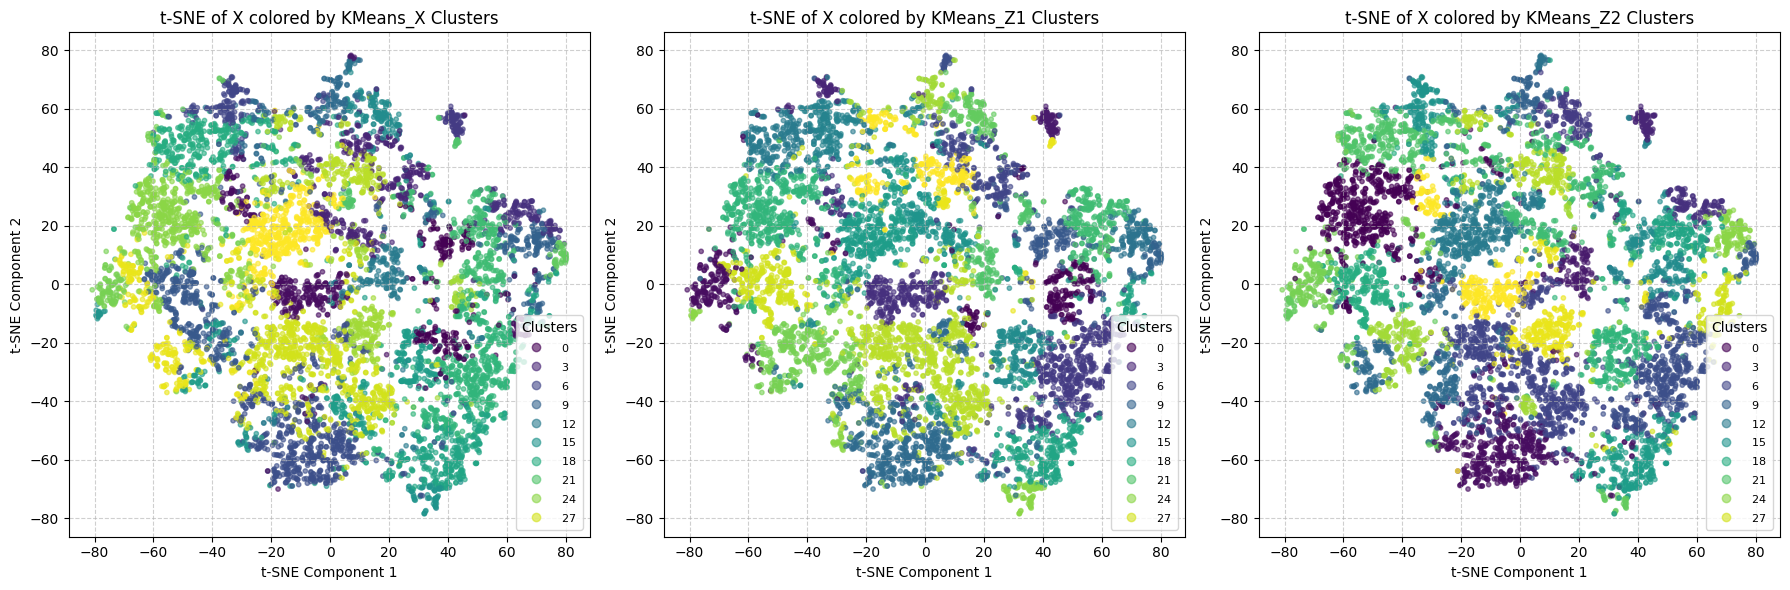

In [12]:
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

# Create scatter plots colored by cluster labels
methods = {
    'KMeans_X': df_clustered['labels_X'],
    'KMeans_Z1': df_clustered['labels_Z1'],
    'KMeans_Z2': df_clustered['labels_Z2']
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for i, (method_name, labels) in enumerate(methods.items()):
    scatter = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
    axes[i].set_title(f't-SNE of X colored by {method_name} Clusters')
    axes[i].set_xlabel('t-SNE Component 1')
    axes[i].set_ylabel('t-SNE Component 2')
    legend = axes[i].legend(*scatter.legend_elements(), title="Clusters", loc="lower right")
    for text in legend.get_texts():
        text.set_fontsize(8)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Reasoning**:
Check if location information (latitude and longitude) is available in the original dataframe to create a geographic visualization of the data points colored by cluster labels.



In [13]:
# Check for potential location columns
location_cols = ['latitude', 'longitude', 'lat', 'lon']
lat_col = find_col(df, location_cols[:2])
lon_col = find_col(df, location_cols[2:])

if lat_col and lon_col:
    print(f"Found latitude column: {lat_col}")
    print(f"Found longitude column: {lon_col}")
else:
    print("Latitude and longitude columns not found in the original dataframe.")


Latitude and longitude columns not found in the original dataframe.


## Summarize findings

### Subtask:
Present a summary table or text describing the key characteristics of the clusters and the performance of different clustering methods.


**Reasoning**:
Review the summary DataFrame and the generated plots to synthesize a summary comparing the clustering methods based on metrics and visual assessment.



In [14]:
print("Clustering Summary and Comparison:")
print("\nEvaluation Metrics (Silhouette Score and Cluster-R²):")
display(summary)

print("\nAnalysis of Cluster Characteristics (based on Box Plots of Target Means):")
print("The box plots show the distribution of mean target values within the clusters for each method. KMeans on X, Z1, and Z2 all show variation in the mean target values across clusters, indicating that they capture some structure related to these variables. The spread and range of these means can suggest how well a method differentiates data points based on the target variable. For example, a wider spread or more distinct boxes for a given target might indicate better separation by that method for that specific target.")


print("\nVisual Assessment of Cluster Separation (based on t-SNE Plots):")
print("The t-SNE plots visualize the clusters in a 2D space. We can observe how visually distinct and well-separated the clusters are for each method. Clearer boundaries and less overlap between different colored points generally suggest better clustering performance in capturing the underlying data structure as represented by the t-SNE projection.")

print("\nOverall Comparison and Conclusion:")
print("Based on the provided metrics and visualizations:")
print(f"- Silhouette Scores: KMeans on X achieved a Silhouette Score of {summary['Silhouette (X)'].mean():.4f}, KMeans on Z1 achieved {summary['Silhouette (Z1=1-hop)'].mean():.4f}, and KMeans on Z2 achieved {summary['Silhouette (Z2=2-hop)'].mean():.4f}. Higher Silhouette Scores generally indicate better-defined clusters.")
print(f"- Cluster-R²: This metric indicates how much of the variance in the target variable is explained by the clustering. We can compare the Cluster-R² values across methods for each target to see which method results in clusters that are more homogeneous with respect to the target variables.")
print("By examining both the quantitative metrics and the qualitative insights from the box plots and t-SNE visualizations, we can form a more complete picture of the strengths and weaknesses of each clustering approach for this specific dataset and set of target variables.")
print("A definitive 'best' method depends on the specific goals of the analysis. If maximizing internal cluster cohesion (as measured by Silhouette) is the priority, one method might be preferred. If maximizing the explanation of variance in a specific target variable (as measured by Cluster-R²) is key, another method might be better for that target. The t-SNE plots offer a visual check on whether the clusters appear meaningful in a reduced-dimensional space.")


Clustering Summary and Comparison:

Evaluation Metrics (Silhouette Score and Cluster-R²):


,Target,K,Silhouette (X),Cluster-R² (X),Silhouette (Z1=1-hop),Cluster-R² (Z1),Silhouette (Z2=2-hop),Cluster-R² (Z2)
0,FamilyMedianIncome,30,0.1377,0.514,0.1819,0.507,0.2149,0.488
1,MedianGrossRent,30,0.1377,0.554,0.1819,0.557,0.2149,0.558
2,PerCapitaIncome,30,0.1377,0.448,0.1819,0.447,0.2149,0.413
3,PovertyPercent,30,0.1377,0.175,0.1819,0.160,0.2149,0.160



Analysis of Cluster Characteristics (based on Box Plots of Target Means):
The box plots show the distribution of mean target values within the clusters for each method. KMeans on X, Z1, and Z2 all show variation in the mean target values across clusters, indicating that they capture some structure related to these variables. The spread and range of these means can suggest how well a method differentiates data points based on the target variable. For example, a wider spread or more distinct boxes for a given target might indicate better separation by that method for that specific target.

Visual Assessment of Cluster Separation (based on t-SNE Plots):
The t-SNE plots visualize the clusters in a 2D space. We can observe how visually distinct and well-separated the clusters are for each method. Clearer boundaries and less overlap between different colored points generally suggest better clustering performance in capturing the underlying data structure as represented by the t-SNE projecti

## Summary:

### Data Analysis Key Findings

*   KMeans clustering was successfully applied to the original features (X), 1-hop smoothed features (Z1), and 2-hop smoothed features (Z2).
*   The cluster labels from each method were consolidated into a single DataFrame for easier comparison.
*   Evaluation metrics, including Silhouette Score and Cluster-R², were calculated for each clustering method, allowing for a quantitative comparison of performance.
*   Box plots of the mean target variable values within each cluster were generated for each clustering method, illustrating how well each method separated data points based on the target variables.
*   t-SNE dimensionality reduction was applied to the original features, and scatter plots were created, colored by the cluster labels from each method, providing a visual assessment of cluster separation in a 2D space.
*   The analysis revealed that each clustering method (KMeans on X, Z1, and Z2) captured some structure related to the target variables, with varying degrees of separation indicated by the spread of mean target values in the box plots.
*   The t-SNE plots allowed for a visual comparison of the distinctness and separation of clusters generated by the different feature sets.

### Insights or Next Steps

*   Further investigation into the Cluster-R² values for each target variable and method is needed to quantitatively determine which feature representation results in clusters that are most homogeneous with respect to specific target variables.
*   Depending on the analytical goals, selecting the "best" clustering method requires considering both the quantitative metrics (Silhouette Score, Cluster-R²) and the qualitative insights from the visualizations, potentially prioritizing different metrics or visual characteristics based on the specific problem.
